# Given a data which contains many properties/features of molecules. Develop a machine learning model to predict the ground state energies of all molecules

## 1. Work with data to export important features

<font color='blue'>
First, load the module needed

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.unicode_minus'] = False

import tensorflow as tf

import itertools

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<font color='blue'>
Load the data

In [2]:
df_data = pd.read_csv('2000_roboBohr.csv')
df_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


<font color='blue'>
Remove non-feature data

In [3]:
df_data = df_data.drop(['Unnamed: 0', 'pubchem_id'], axis = 1)
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1266,1267,1268,1269,1270,1271,1272,1273,1274,Eat
0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,-19.013763
1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.161019
2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.376619
3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.776438
4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.537140


<font color='blue'>
Split data into training set and test set

In [4]:
# list of columns not to be used for training
LABEL = "Eat"
X = df_data.drop([LABEL], axis = 1)
Y = df_data[LABEL]
FEATURES = list(X.columns)
print ("len(FEATURES)=", len(FEATURES))
print ("LABEL=",LABEL)

# split into training and test for the purposes of this demonstration
test_size = 0.2
rstate = 42
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X, Y, 
                                                            test_size=test_size,
                                                            random_state=rstate)

# for neural network 
NNy_train_E = pd.DataFrame(y_train_E, columns = [LABEL])
NNy_test_E = pd.DataFrame(y_test_E, columns = [LABEL])
training_set = pd.DataFrame(X_train_E, columns = FEATURES).merge(NNy_train_E, left_index = True, right_index = True)
testing_set = pd.DataFrame(X_test_E, columns = FEATURES).merge(NNy_test_E, left_index = True, right_index = True)

len(FEATURES)= 1275
LABEL= Eat


## 2. Random forest regression

In [5]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

method = RandomForestRegressor(random_state=rstate)
tuned_parameters_ = [{'max_depth': [3,5]},
                    {'n_estimators':[50,100]}]
n_folds = 4
gs = GridSearchCV(method, param_grid= tuned_parameters_, cv=n_folds)

gs_result = gs.fit(X_train_E, y_train_E)

/Users/pham20/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/pham20/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/pham20/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/pham20/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/pham20/.local/lib/python3.6/site-packages/skl

In [6]:
# report the most important featuers for predicting each target

# collect ranking of most "important" features for E
#importances_E =  gs.feature_importances_
#descending_indices_E = np.argsort(importances_E)[::-1]
#sorted_importances_E = [importances_E[idx] for idx in descending_indices_E]
#sorted_features_E = [idx for idx in descending_indices_E]
#print('most important feature for formation energy is %s' % sorted_features_E[0])


In [7]:
# evaluate performance of the random forest models

def rmsle(actual, predicted):
    """
    Args:
        actual (1d-array) - array of actual values (float)
        predicted (1d-array) - array of predicted values (float)
    Returns:
        root mean square log error (float)
    """
    return np.sqrt(np.mean(np.power(actual-predicted, 2)))

def plot_actual_pred(train_actual, train_pred, 
                     test_actual, test_pred,
                     target):
    """
    Args:
        train_actual (1d-array) - actual training values (float)
        train_pred (1d-array) - predicted training values (float)
        test_actual (1d-array) - actual test values (float)
        test_pred (1d-array) - predicted test values (float)
        target (str) - target property
    Returns:
        matplotlib scatter plot of actual vs predicted
    """
    s = 75
    lw = 0
    alpha = 0.2
    train_color = 'orange'
    train_marker = 's'
    test_color = 'blue'
    test_marker = '^'
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 16
    label = '__nolegend__'
    ax = plt.scatter(train_pred, train_actual,
                     marker=train_marker, color=train_color, s=s, 
                     lw=lw, alpha=alpha, label='train')
    ax = plt.scatter(test_pred, test_actual,
                     marker=test_marker, color=test_color, s=s, 
                     lw=lw, alpha=alpha, label='test')
    ax = plt.legend(frameon=False, fontsize=fontsize, handletextpad=0.4)    
    all_vals = list(train_pred) + list(train_actual) + list(test_pred) + list(test_actual)
    full_range = abs(np.max(all_vals) - np.min(all_vals))
    cushion = 0.1
    xmin = np.min(all_vals) - cushion*full_range
    xmax = np.max(all_vals) + cushion*full_range
    ymin = xmin
    ymax = xmax    
    ax = plt.xlim([xmin, xmax])
    ax = plt.ylim([ymin, ymax])
    ax = plt.plot([xmin, xmax], [ymin, ymax], 
                  lw=axis_width, color='black', ls='--', 
                  label='__nolegend__')
    ax = plt.xlabel('predicted ' + target, fontsize=fontsize)
    ax = plt.ylabel('actual ' + target, fontsize=fontsize)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    return ax

RMSLE for target values = 0.089 (training) and 0.272 (test)


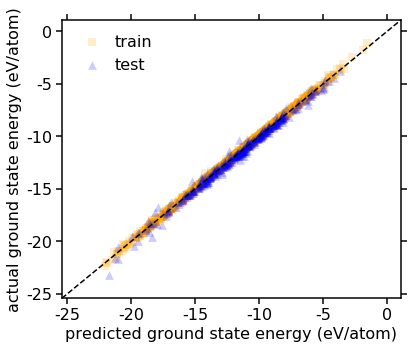

In [8]:
y_train_E_pred = gs_result.predict(X_train_E)
y_test_E_pred = gs_result.predict(X_test_E)
target_E = 'ground state energy (eV/atom)'
print('RMSLE for target values = %.3f (training) and %.3f (test)' 
      % (rmsle(y_train_E, y_train_E_pred),  (rmsle(y_test_E, y_test_E_pred))))

fig4 = plt.figure(4, figsize=(11,5))
ax1 = plt.subplot(121)
ax1 = plot_actual_pred(y_train_E, y_train_E_pred,
                       y_test_E, y_test_E_pred,
                       target_E)
plt.tight_layout()
plt.show()
plt.close()

## 3. Neural network with keras

In [30]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

seed = 7
np.random.seed(seed)

# Model
model = Sequential()
model.add(Dense(800, input_dim=len(FEATURES), kernel_initializer='normal', activation='relu'))
model.add(Dense(400, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())

model.fit(X_train_E, y_train_E, epochs=100, batch_size = 10)
#model.fit(X_train_E, y_train_E, epochs=10, batch_size = 10, validation_split=0.33)
#model.fit(X_train_E, y_train_E, epochs=100, batch_size = 10, validation_data=(X_test_E, y_test_E))

model.evaluate(X_train_E, y_train_E)

Epoch 1/100
1599/1599 [==============================] - 4s 2ms/step - loss: 16.1431
Epoch 2/100
1599/1599 [==============================] - 3s 2ms/step - loss: 6.8600
Epoch 3/100
1599/1599 [==============================] - 3s 2ms/step - loss: 4.7427
Epoch 4/100
1599/1599 [==============================] - 3s 2ms/step - loss: 3.8559
Epoch 5/100
1599/1599 [==============================] - 3s 2ms/step - loss: 3.2274
Epoch 6/100
1599/1599 [==============================] - 3s 2ms/step - loss: 2.9038
Epoch 7/100
1599/1599 [==============================] - 3s 2ms/step - loss: 2.8016
Epoch 8/100
1599/1599 [==============================] - 3s 2ms/step - loss: 2.3043
Epoch 9/100
1599/1599 [==============================] - 3s 2ms/step - loss: 2.7296
Epoch 10/100
1599/1599 [==============================] - 3s 2ms/step - loss: 1.8180
Epoch 11/100
1599/1599 [==============================] - 3s 2ms/step - loss: 2.5626
Epoch 12/100
1599/1599 [==============================] - 3s 2ms/step - l

1599/1599 [==============================] - 3s 2ms/step - loss: 0.2718
Epoch 98/100
1599/1599 [==============================] - 3s 2ms/step - loss: 0.3412
Epoch 99/100
1599/1599 [==============================] - 3s 2ms/step - loss: 0.2671
Epoch 100/100
1599/1599 [==============================] - 0s 220us/step


0.12120329864495541

RMSLE for target values = 0.348 (training) and 0.780 (test)


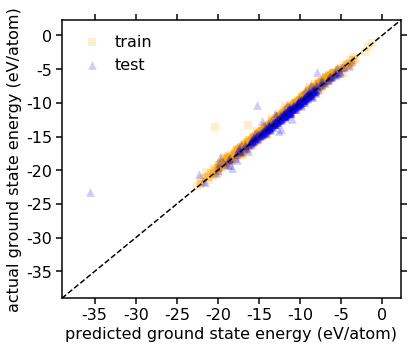

In [31]:
y_train_E_pred = model.predict(X_train_E)
y_train_E_pred = np.reshape(y_train_E_pred, (y_train_E_pred.shape[0],))

y_test_E_pred = model.predict(X_test_E)
y_test_E_pred = np.reshape(y_test_E_pred, (y_test_E_pred.shape[0],))

target_E = 'ground state energy (eV/atom)'
print('RMSLE for target values = %.3f (training) and %.3f (test)' 
      % (rmsle(y_train_E, y_train_E_pred),  (rmsle(y_test_E, y_test_E_pred))))

fig4 = plt.figure(4, figsize=(11,5))
ax1 = plt.subplot(121)
ax1 = plot_actual_pred(y_train_E, y_train_E_pred,
                       y_test_E, y_test_E_pred,
                       target_E)
plt.tight_layout()
plt.show()
plt.close()

In [11]:
def neural_network(size1, size2, size3):
    model = Sequential()
    model.add(Dense(size1, input_dim=len(FEATURES), kernel_initializer='normal', activation='relu'))
    model.add(Dense(size2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(size3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())
    return(model)

#NN_grid = KerasRegressor(build_fn=neural_network, batch_size = 10, nb_epoch = 10, verbose = 1)

#size1 = [20,20,20]
#size2 = [10,10,10]
#size3 = [5,5,5]

#validator = GridSearchCV(estimator = NN_grid, param_grid = {
#        'size1': size1,
#        'size2': size2,
#        'size3': size3,
#    }, cv = 4)

#grid_result = validator.fit(X_train_E, y_train_E)

## 3. Neural network with tensorflow

In [12]:
# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[2, 2])#,
                                          #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))
#

# Reset the index of training
training_set.reset_index(drop = True, inplace =True)



def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols
#

#
# Deep Neural Network Regressor with the training set which contain the data split by train test split
#regressor.fit(input_fn=lambda: input_fn(training_set), steps=200)
regressor.fit(input_fn=lambda: input_fn(training_set))


ev0 = regressor.evaluate(input_fn=lambda: input_fn(training_set), steps=1)
loss_score0 = ev0["loss"]
print("Final Loss on the training set: {0:f}".format(loss_score0))

ev1 = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)
loss_score1 = ev1["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

KeyboardInterrupt: 

In [ ]:
# Predictions
y0 = regressor.predict(input_fn=lambda: input_fn(training_set))
ytrain = list(itertools.islice(y0, training_set.shape[0]))

y1 = regressor.predict(input_fn=lambda: input_fn(testing_set))
ytest = list(itertools.islice(y1, testing_set.shape[0]))

In [ ]:
fig4 = plt.figure(4, figsize=(11,5))
ax1 = plt.subplot(121)
ax1 = plot_actual_pred(y_train_E, ytrain,
                       y_test_E, ytest,
                       target_E)
plt.tight_layout()
plt.show()
plt.close()